In [1]:
from ebsco_pubs import ebsco_reader as ebsco
from jhu_covid19 import jhu_reader as jhu
from quandl_stocks import quandl_reader as quandl

import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

def read_data(ebsco_abs_path, jhu_dir_path, quandl_api_key):
    # Get publication data
    pubs = ebsco.read_data(ebsco_abs_path, "COVID-19");

    # Get covid case data
    covid = jhu.read_data(jhu_dir_path)

    # Get NASDAQ data
    nsdq = quandl.read_data(quandl_api_key)

    pubs.index.name = 'Date'
    covid.index.name = 'Date'
    nsdq.index.name = 'Date'
    return covid, pubs, nsdq

def pool_data(covid, pubs, stocks, normalized=False):
    frames = [covid, pubs, stocks]
    result = pd.concat(frames, axis = 1, sort=True).fillna(0)
    if normalized:
        x = result.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        result = pd.DataFrame(x_scaled, columns=result.columns, index=result.index)
    return result
    
def plot_separate(covid = None, pubs = None, stocks = None):
    # plot data
    if covid is not None:
        covid.plot()        
    if pubs is not None:
        pubs.plot() 
    if stocks is not None:
        stocks.plot()
        
    plt.show()

Reading EBSCO search data...
Cleaning data...
Building COVID-19 dataset...
	Reading JHU csv files into pandas.DataFrame...
	Building sums across regions...
	Merging, cleaning, and renaming sums...
Done.
Getting NASDAQ index data from Quandl...
Cleaning data...
Done.


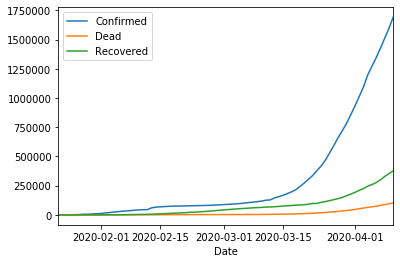

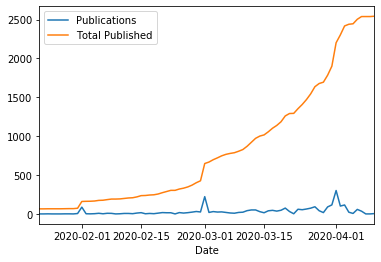

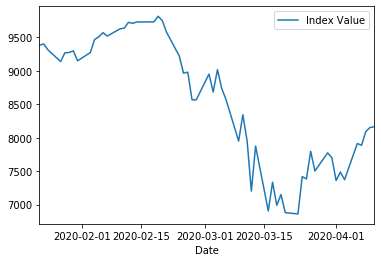

            Confirmed  Dead  Recovered  Publications  Total Published  \
2019-11-01        0.0   0.0        0.0      0.006645         0.000785   
2019-11-02        0.0   0.0        0.0      0.000000         0.000785   
2019-11-03        0.0   0.0        0.0      0.000000         0.000785   
2019-11-04        0.0   0.0        0.0      0.000000         0.000785   
2019-11-05        0.0   0.0        0.0      0.000000         0.000785   
...               ...   ...        ...           ...              ...   
2020-04-12        0.0   0.0        0.0      0.000000         0.997645   
2020-04-13        0.0   0.0        0.0      0.000000         0.997645   
2020-04-14        0.0   0.0        0.0      0.003322         0.998038   
2020-04-15        0.0   0.0        0.0      0.016611         1.000000   
2020-04-16        0.0   0.0        0.0      0.000000         0.000000   

            Index Value  
2019-11-01     0.000000  
2019-11-02     0.000000  
2019-11-03     0.000000  
2019-11-04     0.00

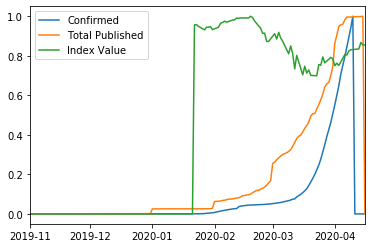

In [2]:
import os

slash = os.path.sep
ebsco_path = "ebsco_pubs"+slash+"rawData.xml"
jhu_path = "jhu_covid19"+slash+"COVID-19"+slash+"csse_covid_19_data"+slash+"csse_covid_19_time_series"+slash
quandl_key = "ksramtjbK7R5TQm9NyDs"

covid, pubs, stocks = read_data(ebsco_abs_path=ebsco_path, jhu_dir_path=jhu_path, quandl_api_key=quandl_key)

# Find which dataset starts latest
min_date = max(min(covid.index), min(pubs.index), min(stocks.index))
# Find which dataset ends first
max_date = min(max(covid.index), max(pubs.index), max(stocks.index))

covid_trim = covid.loc[min_date:max_date]
pubs_trim = pubs.loc[min_date:max_date]
stocks_trim = stocks.loc[min_date:max_date]
plot_separate(covid_trim, pubs_trim, stocks_trim)

#pubs = pubs_trim

pool = pool_data(covid=covid, 
                 pubs=pubs,
                 stocks=stocks,
                normalized=True)
print(pool)
pool[['Confirmed', 'Total Published', 'Index Value']].plot()
plt.show()